In [2]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import mdtraj as md
import pickle
import glob
import sys
import os
sys.path.append('/home/xgu/Tiwary/S100/rave/scripts')
import S100CVs as scv
# from openmm_utils import *
os.system('pwd')
import networkx as nx
import matplotlib.cm as cm
from collections import Counter

/home/xgu/Tiwary/S100_clean


In [4]:
def spib_color(spib_labels):
    cmap = matplotlib.colormaps["tab20"]
    c_array=np.where(np.reshape(spib_labels,(spib_labels.shape[0]*spib_labels.shape[1],spib_labels.shape[2]))==1)[1]
    sets=list(set(c_array))
    color_dict={}
    for i in range(len(sets)):
        color_dict[sets[i]]=i
    color_array=[color_dict[col] for col in c_array];
    return color_array

In [5]:
import matplotlib.animation as animation
from PIL import Image  # Pillow library for working with images

# Function to update the frame in the animation
def update(frame):
    img = Image.open(png_files[frame])
    ax.imshow(img)
    # set axis spines (the box around the plot) to be invisible
    plt.setp(ax.spines.values(), alpha = 0)
    # set both tick marks and tick labels to size 0
    ax.tick_params(which = 'both', size = 0, labelsize = 0)
    dt = f"{50*(frame*5+1)} ps"
    ax.set_title(f'dt = {dt}')

**define pocket feature**

In [8]:
from Bio.PDB import PDBParser
parser = PDBParser(QUIET=True)
pdb_file = f'/home/xgu/Tiwary/S100_clean/rAF2/temp_S100B/temp_probs.pdb'
structure = parser.get_structure("X", pdb_file)

predicted_p = []
model = structure[0]
for chain in model:
    for residue in chain:
        rid = residue.get_id()[1]
        for atom in residue:
            coordinates = atom.get_coord()
            b_factor = atom.get_bfactor() 
            if b_factor > 0.2:        
                predicted_p.append(rid-1)
                break
predicted_p = list(set(predicted_p))
print(predicted_p, len(predicted_p))
predicted_p.extend([84,87,88]) # add more residues for the c-terminal features

[36, 43, 44, 45, 46, 47, 75, 76, 79, 80, 52, 55, 56, 58, 59, 60] 16


In [12]:
r_pair = []
for i in range(len(predicted_p)):
    for j in range(i+1, len(predicted_p)):
        if abs(predicted_p[i]-predicted_p[j]) < 10:
            r_pair.append([predicted_p[i],predicted_p[j]])
np.savetxt('index_pocket.txt', r_pair, fmt='%d')

In [13]:
len(r_pair)

53

In [4]:
wkdir = "/home/xgu/Tiwary/S100_clean/spib_L_ticatica/"
parent = "/home/xgu/Tiwary/S100_clean/spib_G_tica/"
os.chdir(wkdir)
# lags = np.arange(500, 8100, 500)
hyper = 'b=0.0100_learn=0.001000_'
lags = np.arange(5, 500, 25)

**SPIB dt screening**

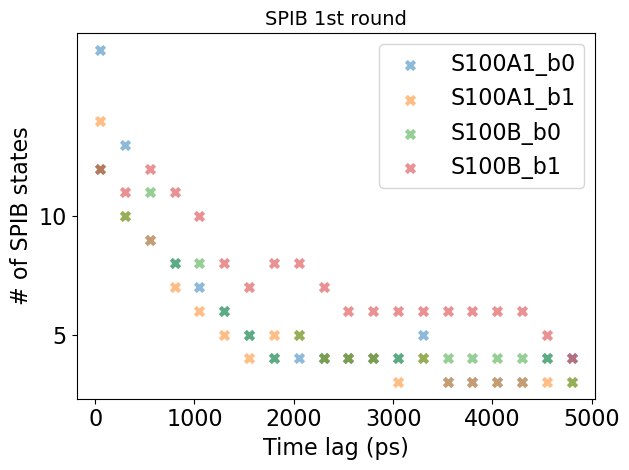

In [11]:
for sys in ['S100A1','S100B']:
    for basin in [0, 1]:
        prot = f'{sys}_b{basin}'
        listindices = glob.glob(f'{prot}/{prot}_input/colvar*')
        nstates=[]
        for lag in lags:
            prefix=f"{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
            spib_labels=[np.load(prefix+"traj%i_labels0.npy"%i) for i in range(len(listindices))]
            spib_labels = np.concatenate(spib_labels)
            c_array=np.where(spib_labels==1)[1]
            nstate = len(set(c_array))
            nstates.append(nstate)
        plt.scatter(lags*10, nstates, marker='x', linewidth=3, label=f'{prot}',alpha=0.5)

plt.xlabel('Time lag (ps)', fontsize=16)
plt.ylabel('# of SPIB states', fontsize=16)
plt.xticks(np.arange(0,5100,1000), fontsize=16)
plt.yticks([5,10], fontsize=16)
plt.legend(fontsize=16)
plt.title("SPIB 1st round", fontsize=14)
plt.tight_layout()
# plt.savefig(f"SPIB_1_states.png",dpi=300)

In [12]:
op_id = [int(x) for x in range(53)]
for sys in ['S100A1','S100B']:
    for basin in [0, 1]:
        prot = f'{sys}_b{basin}'
        op_max = np.load(f"{prot}/{prot}_input/max_unb.npy")
        op_min = np.load(f"{prot}/{prot}_input/min_unb.npy")

        ls = []
        listindices = glob.glob(f"{prot}/{prot}_input/CV*")
        for i in range(len(listindices)):
            ls.append((np.loadtxt(f"{prot}/{prot}_input/CVs_{i}.txt")[:,op_id]-op_min)/(op_max-op_min))

        ls_array=np.array(ls)
        ls_array=np.reshape(ls_array,(ls_array.shape[0]*ls_array.shape[1],ls_array.shape[2]))

        input_index=[np.ones(ls[i].shape[0],dtype=int)+i for i in range(len(listindices))]
        input_index=np.array(input_index)
        input_color=np.reshape(input_index,(input_index.shape[0]*input_index.shape[1]))

        for lag in lags:
            dt = f"{lag*1e-2} ns"
            prefix=f"{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
            weights=np.load(prefix+"z_mean_encoder_weight0.npy")

            md_array = np.dot(ls_array, weights.T)

            spib_labels=[np.load(prefix+"traj%i_labels0.npy"%i) for i in range(len(listindices))]
            spib_labels=np.array(spib_labels)
            color_array=spib_color(spib_labels)


            fig = plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plot=plt.scatter(md_array.T[0],md_array.T[1],c=input_color,s=1,alpha=0.5,cmap="tab20")
            plt.title('Unbiased MD input traj in L space',y=1.0)
            plt.xlabel("$\sigma_1$",fontsize=15)
            plt.ylabel("$\sigma_2$",fontsize=15)
            plt.ylim([min(md_array.T[1])-0.2,max(md_array.T[1])+0.2])
            plt.xlim([min(md_array.T[0])-0.1,max(md_array.T[0])+0.1])
            cbar = plt.colorbar(plot)
            cbar.set_ticks([])

            plt.subplot(1,2,2)
            plot=plt.scatter(md_array.T[0],md_array.T[1],s=1,alpha=0.5,c=color_array,cmap="tab20")
            plt.title('Unbiased MD SPIB states in L space',y=1.0)
            plt.xlabel("$\sigma_1$",fontsize=15)
            plt.ylabel("$\sigma_2$",fontsize=15)
            plt.ylim([min(md_array.T[1])-0.2,max(md_array.T[1])+0.2])
            plt.xlim([min(md_array.T[0])-0.1,max(md_array.T[0])+0.1])
            plt.colorbar(plot)


            plt.subplots_adjust(hspace=0.3, wspace=0.2)
            plt.savefig(f"{prot}/lspace_{prot}_{lag}.png",dpi=300)
            plt.close()

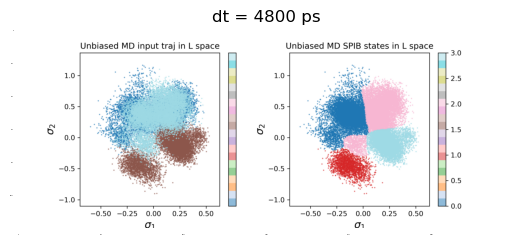

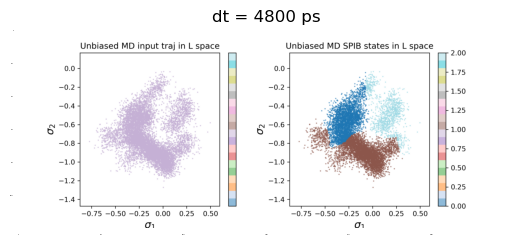

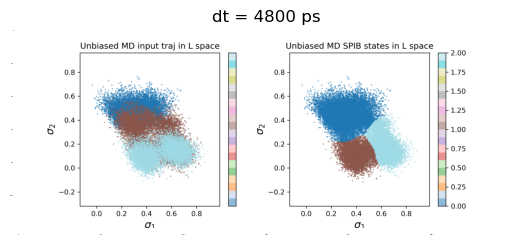

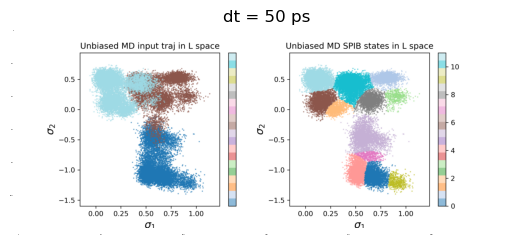

In [14]:
for sys in ['S100A1','S100B']:
    for basin in [0, 1]:
        prot = f'{sys}_b{basin}'
        png_files=[]
        for lag in lags:
            png_files.append(f"{prot}/lspace_{prot}_{lag}.png")
        fig, ax = plt.subplots()
        ani = animation.FuncAnimation(fig, update, frames=len(png_files), interval=200)
        ani.save(f'{prot}/{prot}.mp4', writer='ffmpeg', fps=2,dpi=300)

*dt=300 ps is selected*

**SPIB_L FES**

In [17]:
#wham
lag = 30
# generate input for WHAM metafile
for prot in ['S100A1_b1', 'S100B_b0']:
    op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
    op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")
    prefix=f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
    wts=np.load(prefix+"z_mean_encoder_weight0.npy")
    
    if not os.path.isdir(f'{wkdir}/IB_{prot}_{lag}'):
        os.mkdir(f'{wkdir}/IB_{prot}_{lag}')

    tmp=[]
    cv_files = glob.glob(f"{wkdir}/{prot}/{prot}_input/CVs*txt")        
    for fi in range(len(cv_files)):
        cv = np.loadtxt(f'{wkdir}/{prot}/{prot}_input/CVs_{fi}.txt')
        cv_norm = (cv-op_min)/(op_max-op_min)
        IBs = np.dot(cv_norm, wts.T)
        tmp.append(IBs)
        IBs = np.hstack((np.arange(len(IBs)).reshape(-1, 1), IBs))
        np.savetxt(f'{wkdir}/IB_{prot}_{lag}/{prot}_{fi}.txt', IBs, fmt='%.5f')
    tmp=np.concatenate(tmp)
    # Print data range for 2 IBs
    print("MAX for IB1, IB2:", np.max(tmp, axis=0), "MIN for IB1, IB2:", np.min(tmp, axis=0))
    IB1_max = np.ceil(np.max(tmp, axis=0)[0]*10)/10
    IB2_max = np.ceil(np.max(tmp, axis=0)[1]*10)/10
    IB1_min = np.floor(np.min(tmp, axis=0)[0]*10)/10
    IB2_min = np.floor(np.min(tmp, axis=0)[1]*10)/10
    
 
    # write metadata file
    file_path = f'{wkdir}/IB_{prot}_{lag}/{prot}_meta.txt'
    cv_files = glob.glob(f'{wkdir}/{prot}/{prot}_input/CVs*txt')
    with open(file_path, 'w') as file:
        for fi in range(len(cv_files)):
            file.write(f"{wkdir}/IB_{prot}_{lag}/{prot}_{fi}.txt 0 0 0 0\n")          

    #write wham.sh file
    file_path = f'{wkdir}/IB_{prot}_{lag}/{prot}_wham.sh'
    with open(file_path, 'w') as file:
        file.write(f"/home/xgu/wham/wham-2d/wham-2d Px=0 {IB1_min} {IB1_max} 40 Py=0 {IB2_min} {IB2_max} 40 0.00001 300 0 {wkdir}/IB_{prot}_{lag}/{prot}_meta.txt {wkdir}/IB_{prot}_{lag}/{prot}_wham_pmf.txt 1")
    os.chdir(f'{wkdir}/IB_{prot}_{lag}')
    os.system(f'bash {prot}_wham.sh')
    os.chdir(f'{wkdir}')

MAX for IB1, IB2: [0.93674172 0.93690005] MIN for IB1, IB2: [-0.74932839 -1.06281927]
# /home/xgu/wham/wham-2d/wham-2d Px=0 -0.8 1.0 40 Py=0 -1.1 1.0 40 0.00001 300 0 /home/xgu/Tiwary/S100_clean/spib_L_ticatica//IB_S100A1_b1_30/S100A1_b1_meta.txt /home/xgu/Tiwary/S100_clean/spib_L_ticatica//IB_S100A1_b1_30/S100A1_b1_wham_pmf.txt 1
#Number of windows = 1
#Iteration 10:  0.000000
# Dumping simulation biases, in the metadata file order 
# Window  F (free energy units)
# 0	0.000000
# Wall time 0.015625 s
MAX for IB1, IB2: [0.8691555  0.63336187] MIN for IB1, IB2: [-0.16925849 -0.13834137]
# /home/xgu/wham/wham-2d/wham-2d Px=0 -0.2 0.9 40 Py=0 -0.2 0.7 40 0.00001 300 0 /home/xgu/Tiwary/S100_clean/spib_L_ticatica//IB_S100B_b0_30/S100B_b0_meta.txt /home/xgu/Tiwary/S100_clean/spib_L_ticatica//IB_S100B_b0_30/S100B_b0_wham_pmf.txt 1
#Number of windows = 3
#Iteration 10:  0.000000
# Dumping simulation biases, in the metadata file order 
# Window  F (free energy units)
# 0	0.000000
# 1	0.000000
# 

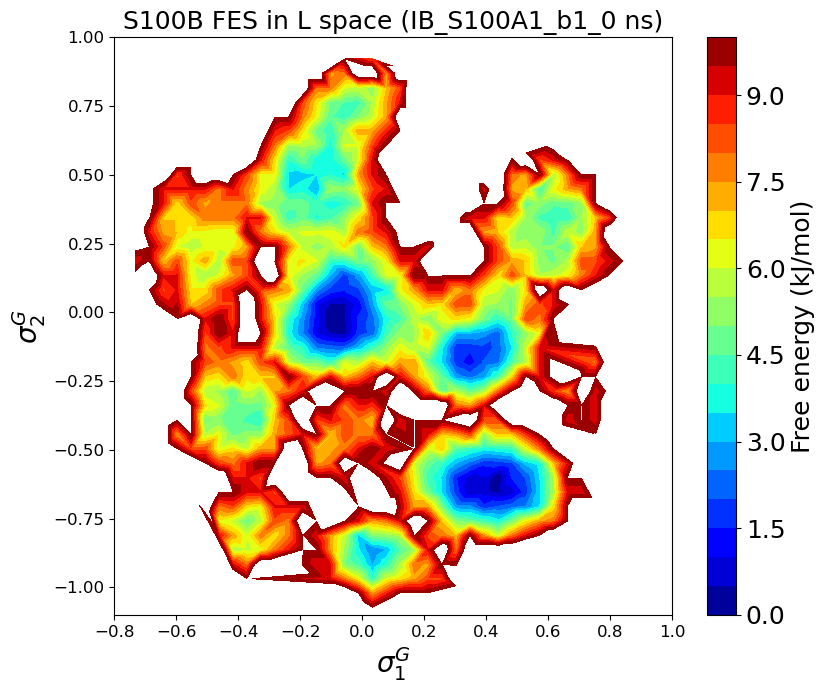

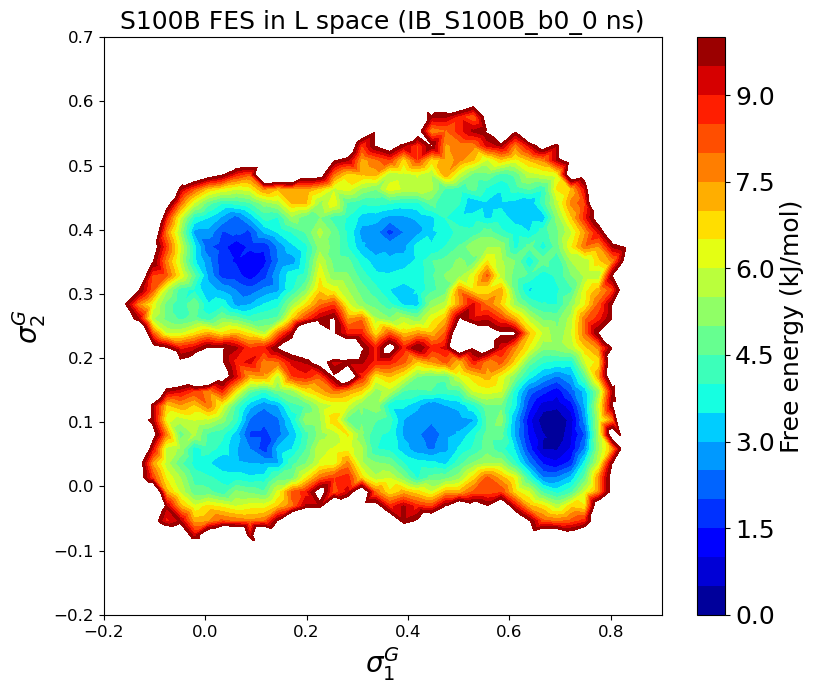

In [21]:
lag = 30
dt = f"{int(lag*1e-2)} ns"
for prot in ['S100A1_b1', 'S100B_b0']:
        prefix = f'{wkdir}/IB_{prot}_{lag}'        
        file_path = f'{prefix}/{prot}_wham.sh'
        with open(file_path, 'r') as file:
            for line in file:
                lim_x = [float(line.split()[2]), float(line.split()[3])]
                lim_y = [float(line.split()[6]), float(line.split()[7])]

        a=pd.read_csv(f'{prefix}/{prot}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')

        a.columns = ['xx', 'yy', 'pmf','prob']
        b=a[a.pmf<9999]

        levels=np.arange(0, 10.5, 0.5)

        plt.figure(figsize=(9,7.5))
        ax = plt.gca()
        minp=np.min(b.pmf)
        CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
        cbar = plt.colorbar(CS, ax=ax)
        cbar.ax.tick_params(labelsize=18)
        cbar.set_label(label='Free energy (kJ/mol)',size=18)

        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)

        plt.title(f'{sys} FES in L space (IB_{prot}_{dt})',y=1.0,fontsize=18)
        plt.xlabel("$\sigma_1^G$",fontsize=20)
        plt.ylabel("$\sigma_2^G$",fontsize=20)
        plt.xlim(lim_x)
        plt.ylim(lim_y)
        # plt.savefig(f"{prefix}_wham_pmf.png",dpi=300)

**Generate MD templates**

In [4]:
# find basins given WHAM PMF file as input
def find_basins_on_FES(wham_file, pmf_cutoff=3):  # basin cutoff default: 3 kJ/mol
    offset = 0.0001 # a very small value to avoid any numerical issue in if conditions
    a=pd.read_csv(wham_file, header=None, delim_whitespace=True, comment='#')
    a.columns = ['xx', 'yy', 'pmf','prob']
    # identify bin size
    X = np.array(sorted(set(a['xx'].to_list())))
    bin0 = X[1]-X[0]
    Y = np.array(sorted(set(a['yy'].to_list())))
    bin1 = Y[1]-Y[0]
    
    b=a[a.pmf<pmf_cutoff]           
    G = nx.Graph()
    G.add_nodes_from(range(len(b)))  

    edges = []
    for i in range(len(b)):
        for j in range(i+1, len(b)):
            if (abs(b.iloc[i].xx - b.iloc[j].xx) > bin0+offset) or (abs(b.iloc[i].yy - b.iloc[j].yy) > bin1+offset):
                continue
            else:
                edges.append((i,j))
    G.add_edges_from(edges)

    groups = list(nx.connected_components(G))
    groups = sorted(groups, key=len, reverse=True)
    
    return b, groups, [bin0, bin1]

In [37]:
# local basin template for tAF2 ensemble
lag = 30
dt = f"{int(lag*1e-2)} ns"
pmf_cutoffs=[2,2] # 3kJ/mol for S100A1_b1, 3kJ/mol for S100B_b0
for isys, prot in enumerate(['S100A1_b1', 'S100B_b0']):
    prefix = f'{wkdir}/IB_{prot}_{lag}'  
    b, groups, bins = find_basins_on_FES(f'{prefix}/{prot}_wham_pmf.txt', pmf_cutoff=pmf_cutoffs[isys])
    # assign MD structures to basins
    sys = prot.split('_')[0]
    ig = int(prot[-1])
    df_traj = pd.read_csv(f'{wkdir}/basin_traj.csv', header=0,sep=',')
    df_tmp = df_traj[(df_traj.name.str.split('_').str[0] == sys) & (df_traj.basin == ig)]
    t_name = df_tmp.name.to_list()
    t_chain = df_tmp.chain.to_list()

    df_final = pd.DataFrame()
    for ilg, g in enumerate(groups):
        df_frames = pd.DataFrame()
        traj_id = []
        traj_name = []
        traj_chain = []
        traj_xx = []
        traj_yy = []
        traj_pmf = []
        tn = b.iloc[list(g)]           
        grids = np.array([tn.xx.values, tn.yy.values]).T 
        
        for t_id in range(len(t_chain)):        
            IBs = pd.read_csv(f'{prefix}/{prot}_{t_id}.txt', header=None, delim_whitespace=True, comment='#')
            IBs.columns = ['frame', 'xx', 'yy']        
            for f_id in range(len(IBs)):                
                txx = IBs.iloc[f_id].xx 
                tyy = IBs.iloc[f_id].yy 
                target = np.array([txx, tyy])
      
                g_id = np.argmin(np.linalg.norm(grids - target, axis=1))    
                if (abs(txx - tn.xx.values[g_id]) <bins[0]) and (abs(tyy - tn.yy.values[g_id]) <bins[1]):
                    traj_id.append(f_id)
                    traj_name.append(t_name[t_id])
                    traj_chain.append(t_chain[t_id])
                    traj_xx.append(txx)
                    traj_yy.append(tyy)
                    traj_pmf.append(tn.pmf.values[g_id]) 
                        
        indices = list(np.linspace(0, len(traj_id) - 1, 20, dtype=int))
        df_frames['t_id'] = np.array(traj_id)[indices]
        df_frames['traj'] = np.array(traj_name)[indices]
        df_frames['chain'] = np.array(traj_chain)[indices]
        df_frames['xx'] = np.array(traj_xx)[indices]
        df_frames['yy'] = np.array(traj_yy)[indices]
        df_frames['pmf'] = np.array(traj_pmf)[indices]
        df_frames['l_basin'] = ilg
        df_final = pd.concat([df_final, df_frames], axis=0)
    df_final.to_csv(f'{prefix}/MD_temp_{prot}.csv', header=True, index=False,)

In [38]:
df_final

,t_id,traj,chain,xx,yy,pmf,l_basin
0,2257,S100B_113_ca,B,0.67934,0.13838,1.676429,0
1,2748,S100B_113_ca,B,0.73972,0.14307,1.239040,0
2,3307,S100B_113_ca,B,0.66868,0.14000,1.676429,0
3,3709,S100B_113_ca,B,0.63956,0.03131,1.438694,0
4,4558,S100B_113_ca,B,0.71483,0.07508,0.867026,0
...,...,...,...,...,...,...,...
15,1830,S100B_163_ca,A,0.43949,0.05948,1.985859,4
16,4177,S100B_163_ca,A,0.45670,0.08875,1.985859,4
17,5348,S100B_163_ca,A,0.46837,0.07983,1.985859,4
18,5662,S100B_163_ca,A,0.43620,0.07272,1.985859,4


/tmp/ipykernel_283/4211692849.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df_frames.xx.tolist(), df_frames.yy.tolist(), marker='*',linewidths=1.5,c=cmap(ilg),edgecolors='black',s=150,label=f'MD temp {ilg}')
/tmp/ipykernel_283/4211692849.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df_frames.xx.tolist(), df_frames.yy.tolist(), marker='*',linewidths=1.5,c=cmap(ilg),edgecolors='black',s=

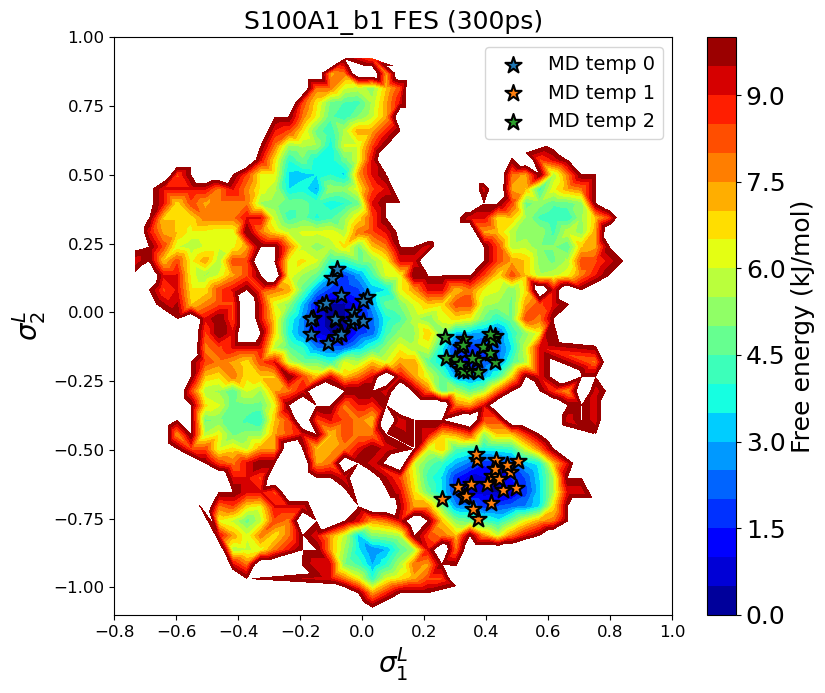

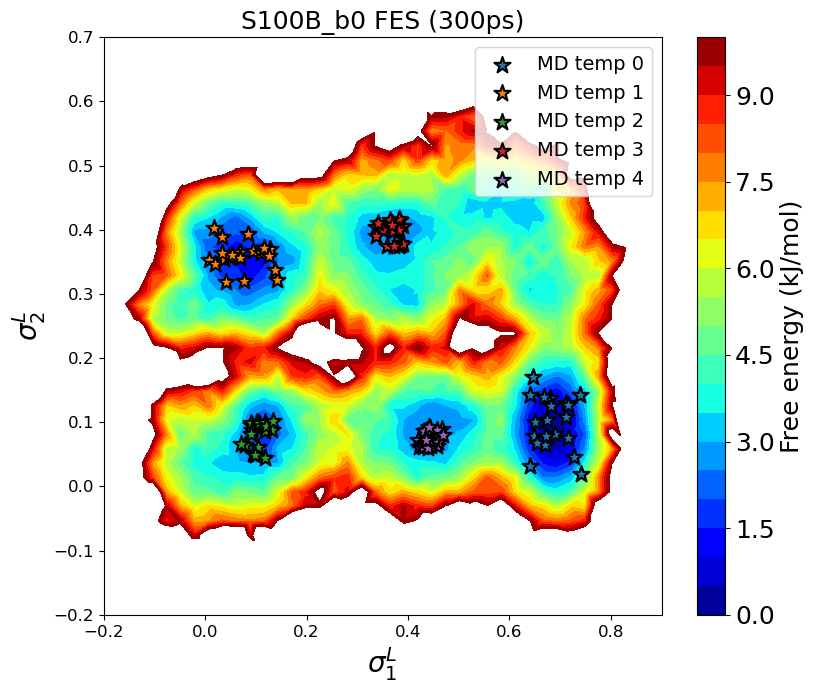

In [19]:
lag = 30
dt = f"{int(lag*1e-2)} ns"
cmap = matplotlib.colormaps['tab10']
for isys, prot in enumerate(['S100A1_b1', 'S100B_b0']):
    prefix = f'{wkdir}/IB_{prot}_{lag}' 
    sys = prot.split('_')[0]
    ig = int(prot[-1])
    file_path = f'{prefix}/{prot}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]

    a=pd.read_csv(f'{prefix}/{prot}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
    a.columns = ['xx', 'yy', 'pmf','prob']
    b=a[a.pmf<9999]

    levels=np.arange(0, 10.5, 0.5)

    plt.figure(figsize=(9,7.5))
    ax = plt.gca()
    minp=np.min(b.pmf)
    CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)


    df_final = pd.read_csv(f'{prefix}/MD_temp_{prot}.csv', header=0, sep=',')
    Ngroup = len(set(df_final['l_basin'].to_list()))
    for ilg in range(Ngroup):
        df_frames = df_final[df_final['l_basin']==ilg]
        plt.scatter(df_frames.xx.tolist(), df_frames.yy.tolist(), marker='*',linewidths=1.5,c=cmap(ilg),edgecolors='black',s=150,label=f'MD temp {ilg}') 


    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.title(f'{prot} FES ({lag}0ps)',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^L$",fontsize=20)
    plt.ylabel("$\sigma_2^L$",fontsize=20)
    plt.xlim(lim_x)
    plt.ylim(lim_y)
    plt.legend(fontsize=14)
    plt.savefig(f"{prefix}/MD_temp_{prot}.png",dpi=300)

In [ ]:
# run mk_temp.py to generate folders for templates and then run tAF2 

In [ ]:
lag = 30
dt = f"{int(lag*1e-2)} ns"
cmap = matplotlib.colormaps['tab10']
for isys, prot in enumerate(['S100A1_b1', 'S100B_b0']):
    prefix = f'{wkdir}/IB_{prot}_{lag}' 
    sys = prot.split('_')[0]
    ig = int(prot[-1])
    file_path = f'{prefix}/{prot}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]

    a=pd.read_csv(f'{prefix}/{prot}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
    a.columns = ['xx', 'yy', 'pmf','prob']
    b=a[a.pmf<9999]

    levels=np.arange(0, 8.5, 0.5)

    plt.figure(figsize=(9,7.5))
    ax = plt.gca()
    minp=np.min(b.pmf)
    CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)


    df_final = pd.read_csv(f'{prefix}/MD_temp_{prot}.csv', header=0, sep=',')
    Ngroup = len(set(df_final['l_basin'].to_list()))
    for ilg in range(Ngroup):
        df_frames = df_final[df_final['l_basin']==ilg]
        plt.scatter(df_frames.xx.tolist(), df_frames.yy.tolist(), marker='*',linewidths=1.5,c=cmap(ilg),edgecolors='black',s=150,label=f'tAF2 {ilg}') 


    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.title(f'{prot} FES ({lag}0ps)',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^L$",fontsize=20)
    plt.ylabel("$\sigma_2^L$",fontsize=20)
    plt.xlim(lim_x)
    plt.ylim(lim_y)
    plt.legend(fontsize=14)
    plt.savefig(f"{prefix}/MD_temp_{prot}.png",dpi=300)

In [80]:
ends = [int(i) for i in np.loadtxt('/home/xgu/Tiwary/S100/rave/scripts/ends.index')]
from collections import deque
def anchor_pairDist(traj):
    anchors = [traj.top.select(f'resid {residue_index} and name CA and chainid 0')[0] for residue_index in ends]
    atom_pairs = []
    for i in range(len(anchors)):
        for j in range(i+1, len(anchors)):
            atom_pairs.append([anchors[i], anchors[j]])
    atom_pairs = np.asarray(atom_pairs)
    dist = md.compute_distances(traj, atom_pairs, periodic=False)
    return dist

def find_distal_atom(topology, residue_index):
    sidechain = topology.select(f"resid {residue_index} and sidechain and not element H") #Residue index (0-based)
    ca_atom = topology.select(f"resid {residue_index} and name CA")

    if len(ca_atom) == 0:
        raise ValueError(f"No alpha carbon found in residue {residue_index}")

    if len(sidechain) == 0:
        return ca_atom[0]
    else:
        # Perform a BFS to find the most distal atom
        max_distance = 0
        distal_atom = ca_atom
        visited = set()
        queue = deque([(ca_atom, 0)])

        while queue:
            current_atom, distance = queue.popleft()
            if distance > max_distance:
                max_distance = distance
                distal_atom = current_atom

            for bond in topology.bonds:
                if bond[0].index == current_atom and (bond[1].index in sidechain):
                    neighbor = bond[1].index
                elif bond[1].index == current_atom and (bond[0].index in sidechain):
                    neighbor = bond[0].index
                else:
                    continue

                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, distance + 1))

        return distal_atom
    
def distal_heavy_atoms_dist(resid1, resid2, top, traj=0):
    select0 = find_distal_atom(top, resid1)
    select1 = find_distal_atom(top, resid2)
    distances = md.compute_distances(traj, [[select0, select1]],periodic=False)
    return distances

id_p = np.loadtxt('/home/xgu/Tiwary/S100/rave/scripts/index_pocket.txt',dtype='int')
def pocket_CVs(traj):
    distA = []
    for cv in id_p:
        distA.append(np.squeeze(distal_heavy_atoms_dist(cv[0], cv[1], traj.top, traj)))
    distA = np.reshape(np.transpose(distA), (-1,len(id_p)))
    return distA

In [82]:
# compute CVs for MD template
sys = 'S100B_b0'
basins = glob.glob(f"/home/xgu/Tiwary/S100_clean/tAF2/temp_{sys}_*")
for basin in basins:
    # dist = []
    # pdbs = glob.glob(f"{basin}/*.pdb")
    # for pdb in pdbs:
    #     traj = md.load(pdb)    
    #     dist.append(anchor_pairDist(traj))
    # 
    # np.savetxt(f"{basin}/anchorDist.txt", dist, fmt='%.5f')
    dist = []
    pdbs = glob.glob(f"{basin}/*.pdb")
    for pdb in pdbs:
        traj = md.load(pdb)    
        dist.append(pocket_CVs(traj))  
    dist = np.squeeze(dist)
    np.savetxt(f"{basin}/pkDist.txt", dist, fmt='%.5f')

In [73]:
# compute CVs for tAF2
sys = 'S100B_b0'
basins = glob.glob(f"/home/xgu/Tiwary/S100_clean/tAF2/{sys}_*")
for basin in basins:
    # dist = []
    # traj = md.load(f"{basin}/structures/pred_1.pdb")    
    # distA, distB = scv.anchor_pairDist(traj)
    # dist.append(distA)
    # dist.append(distB)
    # traj = md.load(f"{basin}/structures/pred_2.pdb")    
    # distA, distB = scv.anchor_pairDist(traj)
    # dist.append(distA)
    # dist.append(distB) 
    # dist = np.squeeze(dist)
    # np.savetxt(f"{basin}/anchorDist.txt", dist, fmt='%.5f')
    
    dist = []
    traj = md.load(f"{basin}/structures/pred_1.pdb")    
    distA, distB = scv.pocket_CVs(traj)
    dist.append(distA)
    dist.append(distB)
    traj = md.load(f"{basin}/structures/pred_2.pdb")    
    distA, distB = scv.pocket_CVs(traj)
    dist.append(distA)
    dist.append(distB)    
    np.savetxt(f"{basin}/pkDist.txt", dist, fmt='%.5f')

*rMD input*

In [44]:
if not os.path.isdir(f'{wkdir}/rMD'):
    os.mkdir(f'{wkdir}/rMD')

In [106]:
# determine CVs to restrain
os.chdir(wkdir)
lag = 30
dt = f"{lag*1e-2} ns"
prot = f'S100B_b0'
id_p = np.loadtxt('/home/xgu/Tiwary/S100_clean/index_pocket.txt',dtype='int')
op_id = [int(x) for x in range(53)]
prefix=f"{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
weights=np.load(prefix+"z_mean_encoder_weight0.npy")
op_max = np.load(f"{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{prot}/{prot}_input/min_unb.npy")
weights = weights/(op_max-op_min)

max0 = np.max(abs(weights[0]))
max1 = np.max(abs(weights[1]))
op_id2 = []
for i in range(len(weights[1])):
    if (abs(weights[0][i]) >= 0.5*max0) or (abs(weights[1][i]) >= 0.5*max1):
        op_id2.append(op_id[i])

In [48]:
traj = md.load(f"tAF2/temp_{prot}_0/0000.pdb")
Lchain = len(traj.top.select('chainid 0 and name CA'))
Lchain

90

In [49]:
df_final = pd.read_csv(f'{wkdir}/IB_{prot}_{lag}/MD_temp_{prot}.csv', header=0, sep=',')
Ngroup = len(set(df_final['l_basin'].to_list()))
for ilg in range(Ngroup):
    df_frames = df_final[df_final['l_basin']==ilg]
    top10 = df_frames.sort_values(by='pmf')[:10]
    cvs = []
    for i in range(10):
        cvs.append(np.loadtxt(f"/home/xgu/Tiwary/S100_clean/unbiasedMD/{top10.iloc[i].traj}/pk_Dist{top10.iloc[i].chain}.txt")[top10.iloc[i].t_id])
    cvs = np.array(cvs)
    
    df_rMD = pd.DataFrame()
    for op in op_id2:
        df = pd.DataFrame()
        df['r_ij'] = cvs[:,op]
        df['res_i'] = id_p[op][0]
        df['res_j'] = id_p[op][1]
        df_rMD = pd.concat([df_rMD, df], axis=0)

        df = pd.DataFrame()
        df['r_ij'] = cvs[:,op]
        df['res_i'] = id_p[op][0] + Lchain
        df['res_j'] = id_p[op][1] + Lchain
        df_rMD = pd.concat([df_rMD, df], axis=0)    
    df_rMD.to_csv(f'rMD/{prot}_{ilg}_rMD.csv', header=True, index=False,)

In [50]:
if not os.path.isdir(f'{wkdir}/rMD/ini_md'):
    os.mkdir(f'{wkdir}/rMD/ini_md')
folders = glob.glob(f'tAF2/{prot}_*')
for folder in folders:
    basin = folder.split('/')[-1]
    os.system(f'cp {folder}/structures/pred_1.pdb {wkdir}/rMD/ini_md/{basin}_pLDDT_rank1.pdb')
    os.system(f'cp {folder}/structures/pred_2.pdb {wkdir}/rMD/ini_md/{basin}_pLDDT_rank2.pdb')
    print(basin)

S100B_b0_0
S100B_b0_1
S100B_b0_2
S100B_b0_3
S100B_b0_4


In [109]:
#rMD
folder = "rMD/final"
rMDs = glob.glob(f"{folder}/*.pdb")
for rMD in rMDs:
    pdb_name = rMD.split('/')[-1][:-4]
    traj = md.load(rMD)
    distA, distB = scv.anchor_pairDist(traj)
    dist = np.squeeze([distA, distB])
    np.savetxt(f'{folder}/{pdb_name}_anchorDist.txt', dist, fmt='%.5f')
    
    distA, distB = scv.pocket_CVs(traj)
    dist = np.squeeze([distA, distB])    
    np.savetxt(f'{folder}/{pdb_name}_pkDist.txt', dist, fmt='%.5f') 

**Projection on latent space**

In [12]:
lag = 30
dt = f"{lag*1e-2} ns"
prot = f'S100B_b0'
op_id = [int(x) for x in range(53)]
prefix=f"{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
wts=np.load(prefix+"z_mean_encoder_weight0.npy")
op_max = np.load(f"{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{prot}/{prot}_input/min_unb.npy")

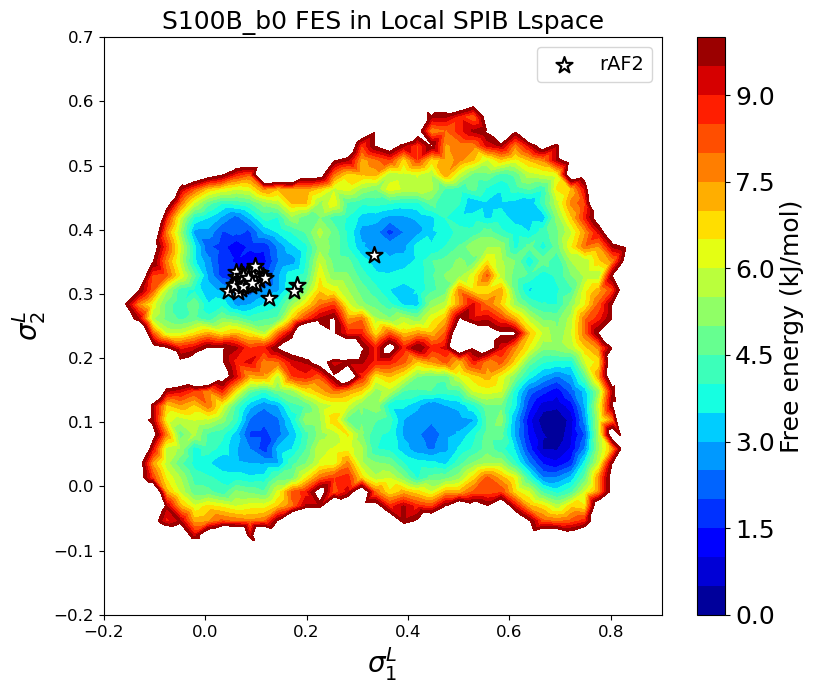

In [18]:
#rAF2
prot = 'S100B_b0'
sys = 'S100B'
ig=0
lag = 30
dt = f"{int(lag*1e-2)} ns"
cmap = matplotlib.colormaps['tab10']

prefix = f'{wkdir}/IB_{prot}_{lag}' 
sys = prot.split('_')[0]
ig = int(prot[-1])
file_path = f'{prefix}/{prot}_wham.sh'
with open(file_path, 'r') as file:
    for line in file:
        lim_x = [float(line.split()[2]), float(line.split()[3])]
        lim_y = [float(line.split()[6]), float(line.split()[7])]

a=pd.read_csv(f'{prefix}/{prot}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
a.columns = ['xx', 'yy', 'pmf','prob']
b=a[a.pmf<9999]

levels=np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9,7.5))
ax = plt.gca()
minp=np.min(b.pmf)
CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
cbar = plt.colorbar(CS, ax=ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='Free energy (kJ/mol)',size=18)
    
#compute pocket IBs for rAF2 falls into given global basin
rAF2_traj_id = [int(i) for i in np.loadtxt(f'{parent}/{sys}_rAF2_GBasin_{ig}.id')]
rAF2_cv = np.loadtxt(f'/home/xgu/Tiwary/S100_clean/rAF2/t_pkDist_{sys}.txt')[:,op_id]
cv_norm = (rAF2_cv-op_min)/(op_max-op_min)
rAF2_IB = np.dot(cv_norm, wts.T)
plt.scatter(rAF2_IB.T[0][rAF2_traj_id], rAF2_IB.T[1][rAF2_traj_id], marker='*',linewidths=1.5,c='white',edgecolors='black',s=150,label=f'rAF2') 

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title(f'{prot} FES in Local SPIB Lspace',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1^L$",fontsize=20)
plt.ylabel("$\sigma_2^L$",fontsize=20)
plt.xlim(lim_x)
plt.ylim(lim_y)
plt.legend(fontsize=14)
plt.savefig(f"{prefix}/{prot}_rAF2.png",dpi=300)

/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3CR4_0_pkDist.txt [0.30036453 0.46341621]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3GK4_0_pkDist.txt [0.0207259  0.36144223]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3HCM_0_pkDist.txt [0.00224095 0.35828778]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3HCM_1_pkDist.txt [0.050921   0.37567896]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3IQQ_0_pkDist.txt [0.11939056 0.27612573]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LK0_0_pkDist.txt [0.41529093 0.30286468]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LK0_1_pkDist.txt [0.40111311 0.33381478]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LK0_2_pkDist.txt [0.24740569 0.34285026]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LK0_3_pkDist.txt [0.07932521 0.30148879]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LLE_0_pkDist.txt [0.21861441 0.29509228]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LLE_1_pkDist.txt [0.31906556 

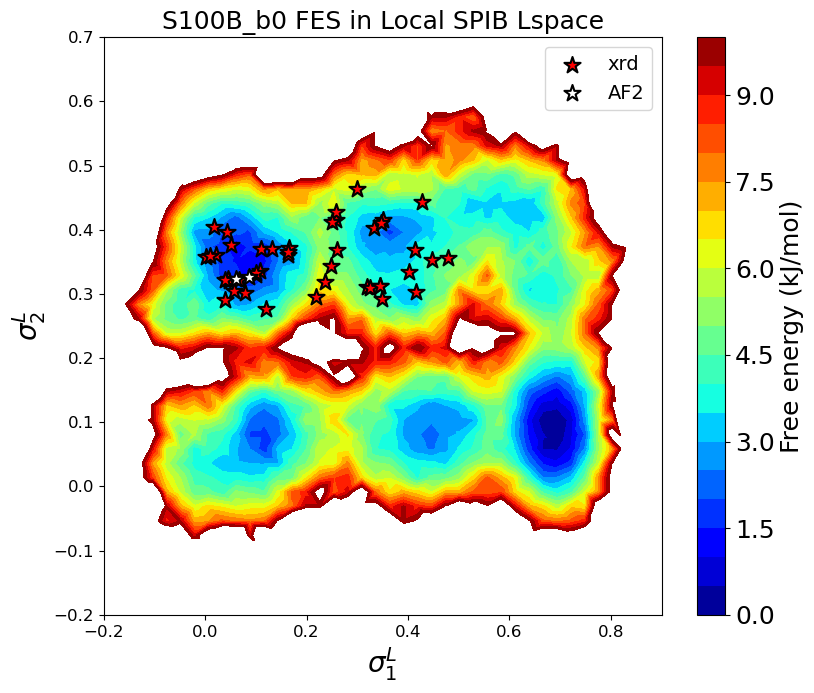

In [17]:
#xrd + AF2
prot = 'S100B_b0'
sys = 'S100B'
ig=0
lag = 30
dt = f"{int(lag*1e-2)} ns"
cmap = matplotlib.colormaps['tab10']

prefix = f'{wkdir}/IB_{prot}_{lag}' 
sys = prot.split('_')[0]
ig = int(prot[-1])
file_path = f'{prefix}/{prot}_wham.sh'
with open(file_path, 'r') as file:
    for line in file:
        lim_x = [float(line.split()[2]), float(line.split()[3])]
        lim_y = [float(line.split()[6]), float(line.split()[7])]

a=pd.read_csv(f'{prefix}/{prot}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
a.columns = ['xx', 'yy', 'pmf','prob']
b=a[a.pmf<9999]

levels=np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9,7.5))
ax = plt.gca()
minp=np.min(b.pmf)
CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
cbar = plt.colorbar(CS, ax=ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='Free energy (kJ/mol)',size=18)
    
#compute pocket IBs for xrd
op_id = [int(x) for x in range(53)]
files = glob.glob(f"/home/xgu/Tiwary/S100/rave/Holo/{sys}/source/mono/*pkDist.txt")
IBs = []
for lid, pdb_file in enumerate(files):  
    cv = np.loadtxt(pdb_file)[op_id]
    cv_norm = (cv-op_min)/(op_max-op_min)
    IB = np.dot(cv_norm, wts.T)
    IBs.append(IB)
    print(pdb_file, IB)
IBs = np.array(IBs)
plt.scatter(IBs.T[0], IBs.T[1], marker='*',linewidths=1.5,c='red',edgecolors='black',s=150,label=f'xrd') 


files = glob.glob(f"/home/xgu/Tiwary/S100/rave/Holo/{sys}/AF2*_pkDist.txt")
IBs = []
for lid, pdb_file in enumerate(files):  
    cv = np.loadtxt(pdb_file)[op_id]
    cv_norm = (cv-op_min)/(op_max-op_min)
    IB = np.dot(cv_norm, wts.T)
    IBs.append(IB)
    print(pdb_file, IB)
IBs = np.array(IBs)
plt.scatter(IBs.T[0], IBs.T[1], marker='*',linewidths=1.5,c='white',edgecolors='black',s=150,label=f'AF2') 


plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title(f'{prot} FES in Local SPIB Lspace',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1^L$",fontsize=20)
plt.ylabel("$\sigma_2^L$",fontsize=20)
plt.xlim(lim_x)
plt.ylim(lim_y)
plt.legend(fontsize=14)
plt.savefig(f"{prefix}/{prot}_xrd.png",dpi=300)    

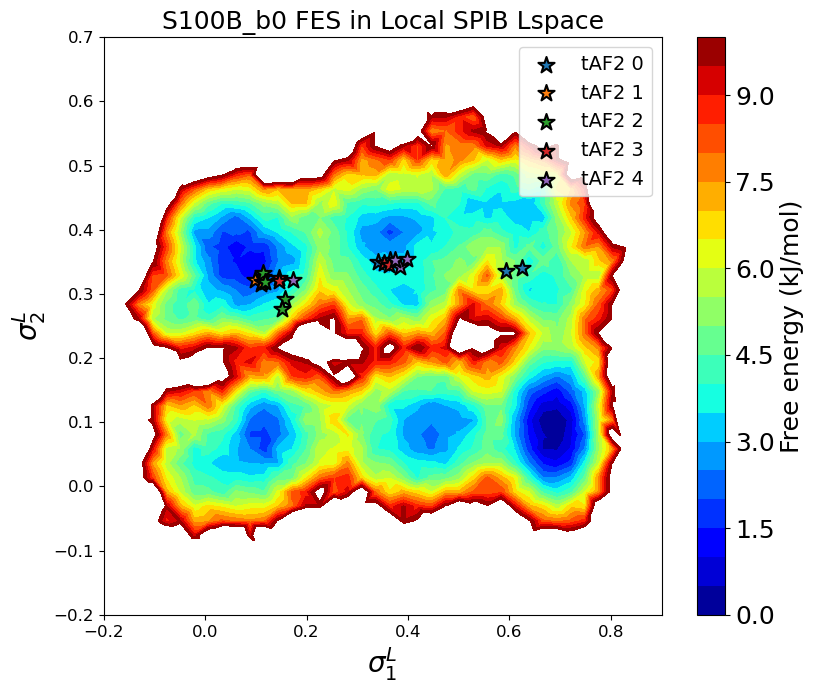

In [27]:
#tAF2 
prot = 'S100B_b0'
sys = 'S100B'
ig=0
lag = 30
dt = f"{int(lag*1e-2)} ns"
cmap = matplotlib.colormaps['tab10']

prefix = f'{wkdir}/IB_{prot}_{lag}' 
sys = prot.split('_')[0]
ig = int(prot[-1])
file_path = f'{prefix}/{prot}_wham.sh'
with open(file_path, 'r') as file:
    for line in file:
        lim_x = [float(line.split()[2]), float(line.split()[3])]
        lim_y = [float(line.split()[6]), float(line.split()[7])]

a=pd.read_csv(f'{prefix}/{prot}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
a.columns = ['xx', 'yy', 'pmf','prob']
b=a[a.pmf<9999]

levels=np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9,7.5))
ax = plt.gca()
minp=np.min(b.pmf)
CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
cbar = plt.colorbar(CS, ax=ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='Free energy (kJ/mol)',size=18)
    
#compute pocket IBs for tAF2
files = glob.glob(f"{wkdir}/tAF2/S100B_b0_*/pkDist.txt")
IBs = []
for lid, pdb_file in enumerate(files):  
    cv = np.loadtxt(pdb_file)[:,op_id]
    cv_norm = (cv-op_min)/(op_max-op_min)
    IB = np.dot(cv_norm, wts.T)
    plt.scatter(IB.T[0], IB.T[1], marker='*',linewidths=1.5,color=cmap(lid),edgecolors='black',s=150,label=f"tAF2 {pdb_file.split('/')[-2][-1]}") 

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title(f'{prot} FES in Local SPIB Lspace',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1^L$",fontsize=20)
plt.ylabel("$\sigma_2^L$",fontsize=20)
plt.xlim(lim_x)
plt.ylim(lim_y)
plt.legend(fontsize=14)
plt.savefig(f"{prefix}/{prot}_tAF2.png",dpi=300) 

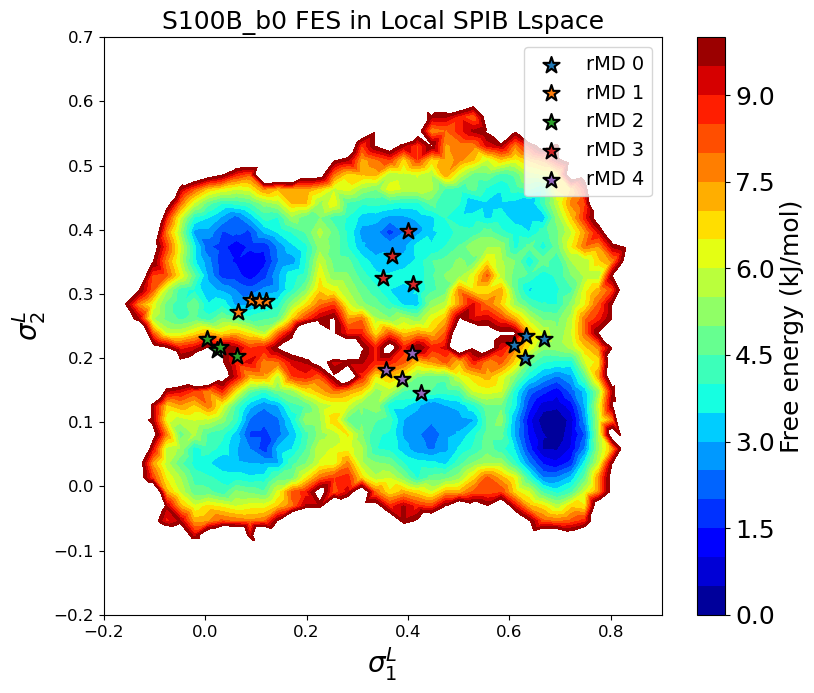

In [28]:
#rMD 
prot = 'S100B_b0'
sys = 'S100B'
ig=0
lag = 30
dt = f"{int(lag*1e-2)} ns"
cmap = matplotlib.colormaps['tab10']

prefix = f'{wkdir}/IB_{prot}_{lag}' 
sys = prot.split('_')[0]
ig = int(prot[-1])
file_path = f'{prefix}/{prot}_wham.sh'
with open(file_path, 'r') as file:
    for line in file:
        lim_x = [float(line.split()[2]), float(line.split()[3])]
        lim_y = [float(line.split()[6]), float(line.split()[7])]

a=pd.read_csv(f'{prefix}/{prot}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
a.columns = ['xx', 'yy', 'pmf','prob']
b=a[a.pmf<9999]

levels=np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9,7.5))
ax = plt.gca()
minp=np.min(b.pmf)
CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
cbar = plt.colorbar(CS, ax=ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='Free energy (kJ/mol)',size=18)
    
#compute pocket IBs for rMD    
folder = "rMD/final"
files = glob.glob(f"rMD/S100B_b0_*_rMD.csv")
for lid in range(len(files)):  
    IBs = []
    pdb_files = glob.glob(f"{folder}/S100B_b0_{lid}_*pkDist.txt")
    for pdb_file in pdb_files:
        cv = np.loadtxt(pdb_file)[:,op_id]
        cv_norm = (cv-op_min)/(op_max-op_min)
        IBs.append(np.dot(cv_norm, wts.T))
    IBs = np.concatenate(IBs)
    # print(IBs)
    plt.scatter(IBs.T[0], IBs.T[1], marker='*',linewidths=1.5,color=cmap(lid),edgecolors='black',s=150,label=f'rMD {lid}')         
    

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title(f'{prot} FES in Local SPIB Lspace',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1^L$",fontsize=20)
plt.ylabel("$\sigma_2^L$",fontsize=20)
plt.xlim(lim_x)
plt.ylim(lim_y)
plt.legend(fontsize=14)
plt.savefig(f"{prefix}/{prot}_rMD.png",dpi=300) 

*SPIB interpretation*

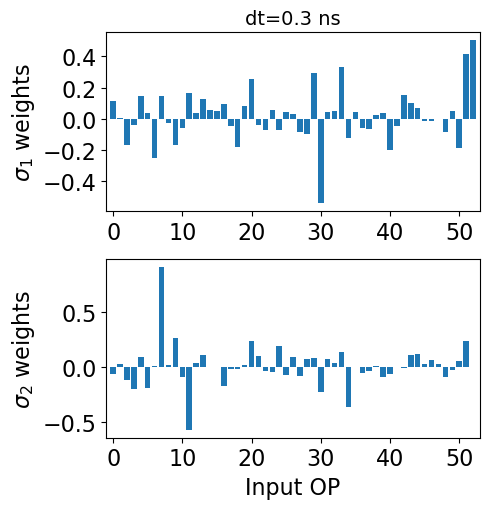

In [16]:
os.chdir(wkdir)
lag = 30
dt = f"{lag*1e-2} ns"
prot = f'S100B_b0'
op_id = [int(x) for x in range(53)]
prefix=f"{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
weights=np.load(prefix+"z_mean_encoder_weight0.npy")
op_max = np.load(f"{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{prot}/{prot}_input/min_unb.npy")
# n_weights = weights/(op_max-op_min)
n_weights = weights

plt.figure(figsize=(5,5.2))
plt.subplot(2,1,1)
plt.bar(op_id,n_weights[0])
plt.ylabel("$\sigma_1$ weights", fontsize=16)
plt.title(f"dt={dt}", fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-1,53)
#plt.tight_layout()
plt.subplot(2,1,2)
plt.bar(op_id,n_weights[1])
plt.ylabel("$\sigma_2$ weights", fontsize=16)
plt.xlabel("Input OP", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-1,53)
plt.tight_layout()
plt.savefig(f"{wkdir}/weights_{prot}_{lag}.png",dpi=300)

In [32]:
res_pairs = np.loadtxt('/home/xgu/Tiwary/S100_clean/index_pocket.txt',dtype=int)

In [33]:
Pairs = []
Wts = []
weights=np.load(prefix+"z_mean_encoder_weight0.npy")
for IB_i in range(len(weights)):
    pairs = []
    wts = []
    maxw = np.max(abs(weights[IB_i]))
    for i in range(len(weights[IB_i])):
        if (abs(weights[IB_i][i]) >= 0.5*maxw):
            pairs.append(list(res_pairs[op_id[i]]))
            wts.append(weights[IB_i][i]/maxw)
    Pairs.append(pairs)
    Wts.append(wts)

In [45]:
traj = md.load("../ini_md/S100B_1_ca.pdb")

In [49]:
Pairs[0]

[[79, 84], [79, 87], [80, 87], [84, 88], [87, 88]]

In [50]:
names = []
for pair in Pairs[0]:
    aid0 = scv.find_distal_atom(traj.top, pair[0])
    atom0 = traj.topology.atom(aid0)
    aid1 = scv.find_distal_atom(traj.top, pair[1])
    atom1 = traj.topology.atom(aid1)
    names.append([atom0.name, atom1.name])
names    

[['CE', 'SG'], ['CE', 'CZ'], ['CD1', 'CZ'], ['SG', 'CZ'], ['CZ', 'CZ']]

In [51]:
Wts[0]

[0.5384327, -1.0, 0.60827106, 0.76105577, 0.9259931]

In [36]:
Pairs[1]

[[43, 52], [44, 52]]

In [37]:
Wts[1]

[1.0, -0.6249991]

In [52]:
names = []
for pair in Pairs[1]:
    aid0 = scv.find_distal_atom(traj.top, pair[0])
    atom0 = traj.topology.atom(aid0)
    aid1 = scv.find_distal_atom(traj.top, pair[1])
    atom1 = traj.topology.atom(aid1)
    names.append([atom0.name, atom1.name])
names   

[['CZ', 'CG1'], ['CD1', 'CG1']]

In [65]:
'+'.join([str(i+1) for i in set(np.concatenate(Pairs).flatten())])

'44+45+80+81+85+53+88+89'